In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,GRU,Dropout,Embedding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
from keras.models import Sequential

In [4]:
enc = LabelEncoder()

In [5]:
data = pd.read_csv('C:\\Users\\gaurav\\miniconda3\\envs\\NLP data\\dataset.csv')

In [6]:
data.shape

(4920, 18)

In [7]:
data_discription = pd.read_csv('C:\\Users\\gaurav\\miniconda3\\envs\\NLP data\\symptom_Description.csv')

In [8]:
data_discription.shape

(41, 2)

In [9]:
Y = data['Disease']

In [10]:
len(set(Y))

41

In [11]:
Y = enc.fit_transform(Y)

In [12]:
len(set(Y))

41

In [13]:
data = data.iloc[:,0:6]

In [14]:
data.fillna(method='backfill',inplace=True)

In [15]:
data

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,cough
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,dischromic _patches,cough
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,dischromic _patches,cough
3,Fungal infection,itching,skin_rash,dischromic _patches,dischromic _patches,cough
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,cough
...,...,...,...,...,...,...
4915,(vertigo) Paroymsal Positional Vertigo,vomiting,headache,nausea,spinning_movements,loss_of_balance
4916,Acne,skin_rash,pus_filled_pimples,blackheads,scurring,small_dents_in_nails
4917,Urinary tract infection,burning_micturition,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,small_dents_in_nails
4918,Psoriasis,skin_rash,joint_pain,skin_peeling,silver_like_dusting,small_dents_in_nails


In [17]:
lem = WordNetLemmatizer()
stopword = stopwords.words('english')

# PreProcessing Text

In [18]:
def preprocess(text):
    corpus=[]
    for i in range(0,len(text)):
        words = re.sub('[^a-zA-Z]',' ',text[i])
        words = words.lower()
        words = words.split()
        words = [lem.lemmatize(word) for word in words if word not in set(stopword)]
        words = ' '.join(words)
        corpus.append(words)
    return corpus

In [19]:
vocab_size=5000

In [20]:
data.columns = [1,2,3,4,5,6]

In [21]:
corpus=[]
for i in range(0,4920):
    words=""
    for j in range(1,7):
        #print(data[j][i])
        words+=data[j][i]
    corpus.append(words)

In [22]:
corp = preprocess(corpus)

# Setting Vocabsize and one hot encoding as well as padding the sequence

In [23]:
vocab_size= 5000

In [24]:
one_hot_representation = [one_hot(word,vocab_size)for word in corp]

In [25]:
print(one_hot_representation[0])
print(corp[0])

[3615, 3874, 3117, 1484, 1459, 3117, 4699, 3080, 3497, 2595]
fungal infectionitching skin rash nodal skin eruption dischromic patch cough


In [26]:
sentence_length=20
embedding_doc = pad_sequences(one_hot_representation,maxlen=sentence_length,padding='pre')

In [27]:
print(one_hot_representation[0])
print(corp[0])
print(embedding_doc[0])

[3615, 3874, 3117, 1484, 1459, 3117, 4699, 3080, 3497, 2595]
fungal infectionitching skin rash nodal skin eruption dischromic patch cough
[   0    0    0    0    0    0    0    0    0    0 3615 3874 3117 1484
 1459 3117 4699 3080 3497 2595]


In [28]:
embedding_doc.shape

(4920, 20)

In [29]:
X = np.array(embedding_doc)
Y = np.array(Y)

In [30]:
X.shape , Y.shape

((4920, 20), (4920,))

# Spliting data into train and test

In [31]:
xtrain,xtest,ytrain,ytest = tts(X,Y,test_size=0.3,random_state=0)

In [32]:
xtrain.shape , xtest.shape

((3444, 20), (1476, 20))

In [33]:
embed_size=100
model = Sequential([
    Embedding(input_dim = vocab_size,output_dim=embed_size,input_length=sentence_length),
    GRU(100,return_sequences=True),
    GRU(120,return_sequences=True),
    Dropout(0.2),
    GRU(150,return_sequences=False),
    Dense(41,activation='softmax')
    
])

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           500000    
_________________________________________________________________
gru_1 (GRU)                  (None, 20, 100)           60300     
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 120)           79560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 120)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 150)               121950    
_________________________________________________________________
dense_1 (Dense)              (None, 41)                6191      
Total params: 768,001
Trainable params: 768,001
Non-trainable params: 0
________________________________________________

In [35]:
model.compile(optimizer=keras.optimizers.Nadam(),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [36]:
hist = model.fit(xtrain,ytrain,epochs=10,validation_data=(xtest,ytest),verbose=1,batch_size=64)

C:\Users\gaurav\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3444 samples, validate on 1476 samples
Epoch 1/10
3444/3444 [==============================] - 21s 6ms/step - loss: 1.6920 - accuracy: 0.5880 - val_loss: 0.1907 - val_accuracy: 0.9661
Epoch 2/10
3444/3444 [==============================] - 18s 5ms/step - loss: 0.0668 - accuracy: 0.9913 - val_loss: 0.0264 - val_accuracy: 0.9986
Epoch 3/10
3444/3444 [==============================] - 18s 5ms/step - loss: 0.0190 - accuracy: 0.9988 - val_loss: 0.0146 - val_accuracy: 0.9986
Epoch 4/10
3444/3444 [==============================] - 18s 5ms/step - loss: 0.0130 - accuracy: 0.9988 - val_loss: 0.0109 - val_accuracy: 0.9986
Epoch 5/10
3444/3444 [==============================] - 19s 5ms/step - loss: 0.0104 - accuracy: 0.9988 - val_loss: 0.0092 - val_accuracy: 0.9986
Epoch 6/10
3444/3444 [==============================] - 19s 5ms/step - loss: 0.0089 - accuracy: 0.9985 - val_loss: 0.0084 - val_accuracy: 0.9986
Epoch 7/10
3444/3444 [==============================] - 18s 5ms/step - loss: 0.007

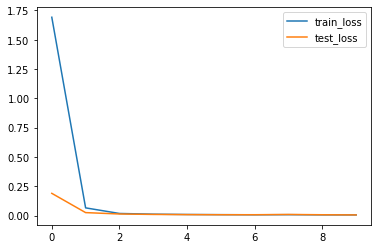

In [37]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train_loss','test_loss'])
plt.show()

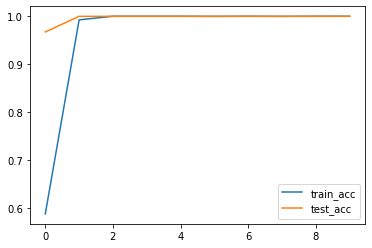

In [38]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train_acc','test_acc'])
plt.show()

In [39]:
pred = model.predict_classes(xtest)

In [40]:
from sklearn.metrics import classification_report,confusion_matrix,balanced_accuracy_score

In [41]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00        33
           5       1.00      1.00      1.00        36
           6       1.00      1.00      1.00        39
           7       1.00      1.00      1.00        41
           8       1.00      1.00      1.00        33
           9       1.00      1.00      1.00        35
          10       1.00      1.00      1.00        42
          11       1.00      1.00      1.00        27
          12       1.00      1.00      1.00        33
          13       1.00      1.00      1.00        40
          14       1.00      1.00      1.00        40
          15       1.00      1.00      1.00        31
          16       1.00      1.00      1.00        42
          17       1.00    

In [42]:
print(balanced_accuracy_score(ytest,pred))

0.9988102320047592


In [56]:
print(confusion_matrix(ytest,pred))

[[32  0  0 ...  0  0  0]
 [ 0 31  0 ...  0  0  0]
 [ 0  0 38 ...  0  0  0]
 ...
 [ 0  0  0 ... 36  0  0]
 [ 0  0  0 ...  0 38  0]
 [ 0  0  0 ...  0  0 38]]


# Saving model and printing the predicted dieseases discription 

In [44]:
model.save('NLP_model.h5')

In [48]:
model.save_weights('C:\\Users\\gaurav\\miniconda3\\envs\\NLP data\\weights.csv')

In [49]:
main_name = enc.inverse_transform(pred)

In [84]:
l1 = list(data_discription['Disease'])

In [89]:
l1[0]

'Drug Reaction'

In [86]:
l2 = list(data_discription['Description'])

In [88]:
l2[0]

'An adverse drug reaction (ADR) is an injury caused by taking medication. ADRs may occur following a single dose or prolonged administration of a drug or result from the combination of two or more drugs.'

In [80]:
discription_report={}

In [91]:
for i,j in zip(l1,l2):
    discription_report[i] = j 

In [100]:
def return_predicted_dieseases_discription(text):
    if(text not in discription_report):
        return None
    return discription_report[str(text)]

In [111]:
def print_diesease_discription(main_name):
    for i in main_name:
        print("Diseases : %s\nDiscription : %s " %(i,return_predicted_dieseases_discription(i)), end=" " )
        print("\n")

In [112]:
print_diesease_discription(main_name)

Diseases : Heart attack
Discription : The death of heart muscle due to the loss of blood supply. The loss of blood supply is usually caused by a complete blockage of a coronary artery, one of the arteries that supplies blood to the heart muscle.  

Diseases : hepatitis A
Discription : Hepatitis A is a highly contagious liver infection caused by the hepatitis A virus. The virus is one of several types of hepatitis viruses that cause inflammation and affect your liver's ability to function.  

Diseases : Tuberculosis
Discription : Tuberculosis (TB) is an infectious disease usually caused by Mycobacterium tuberculosis (MTB) bacteria. Tuberculosis generally affects the lungs, but can also affect other parts of the body. Most infections show no symptoms, in which case it is known as latent tuberculosis.  

Diseases : Hypoglycemia
Discription :  Hypoglycemia is a condition in which your blood sugar (glucose) level is lower than normal. Glucose is your body's main energy source. Hypoglycemia 

Discription : Inflammation of the liver due to the hepatitis C virus (HCV), which is usually spread via blood transfusion (rare), hemodialysis, and needle sticks. The damage hepatitis C does to the liver can lead to cirrhosis and its complications as well as cancer.  

Diseases : Pneumonia
Discription : Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli. The alveoli fill with fluid or pus, making it difficult to breathe.  

Diseases : Osteoarthristis
Discription : Osteoarthritis is the most common form of arthritis, affecting millions of people worldwide. It occurs when the protective cartilage that cushions the ends of your bones wears down over time.  

Diseases : Common Cold
Discription : The common cold is a viral infection of your nose and throat (upper respiratory tract). It's usually harmless, although it might not feel that way. Many types of viruses can

Discription : Urinary tract infection: An infection of the kidney, ureter, bladder, or urethra. Abbreviated UTI. Not everyone with a UTI has symptoms, but common symptoms include a frequent urge to urinate and pain or burning when urinating.  

Diseases : GERD
Discription : Gastroesophageal reflux disease, or GERD, is a digestive disorder that affects the lower esophageal sphincter (LES), the ring of muscle between the esophagus and stomach. Many people, including pregnant women, suffer from heartburn or acid indigestion caused by GERD.  

Diseases : Hyperthyroidism
Discription : Hyperthyroidism (overactive thyroid) occurs when your thyroid gland produces too much of the hormone thyroxine. Hyperthyroidism can accelerate your body's metabolism, causing unintentional weight loss and a rapid or irregular heartbeat.  

Diseases : Jaundice
Discription : Yellow staining of the skin and sclerae (the whites of the eyes) by abnormally high blood levels of the bile pigment bilirubin. The yellowi

In [2]:
##### Flask Part Start##

In [5]:
from wtforms import (Form, TextField, validators, SubmitField, 
DecimalField, IntegerField)

class ReusableForm(Form):
    """User entry form for entering specifics for generation"""
    # Starting seed
    seed = TextField("Enter a seed string or 'random':", validators=[
                     validators.InputRequired()])
    submit = SubmitField("Enter")

In [ ]:
r = ReusableForm()